# Aprendizaje basado en instancias

## Procesado de los datos

El conjunto de datos sobre cáncer de mama está incluido en *Scikit-learn*, se obtiene usando la función `load_breast_cancer` incluida en la librería `sklearn.datasets`. Este conjunto de datos contiene 569 ejemplos con 30 características sobre clasificaciones de cáncer de mama, con dos clasificaciones posibles.

In [1]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

Este conjunto de datos es un diccionario con varios campos:
* `data`: Es el conjunto de datos, se trata de un array en el que cada componente es un array con las características de cada instancia.
* `target`: Es el conjunto de valores de clasificación para cada instancia. Es un array del mismo tamaño que `data`, en el que se indica el valor de clasificación de cada instancia, en el mismo orden en que éstas se encuentran en el array `data`.
* `DESCR`: Es una descripción del conjunto de datos.
* `target_names`: Es un array con los nombres de cada valor de clasificación.
* `feature_names`: Es un array con los nombres de cada característica.

Almacenamos los datos en las variables `X_data`, `y_data`, `X_names` e `y_names`.

In [2]:
X_data, y_data, X_names, y_names = \
    cancer.data, cancer.target, cancer.feature_names, cancer.target_names

## Ejemplos aislados (*outliers*)

Un ejemplo aislado (*outlier* en inglés) es un ejemplo de entrenamiento que está rodeado por ejemplos que no pertenecen a su misma clase. La presencia de ejemplos aislados en un conjunto de entrenamiento puede deberse a:

* Un error en los datos
* Una cantidad insuficiente de ejemplos de la clase de los ejemplos aislados
* La existencia de características que no se están teniendo en cuenta
* Clases desbalanceadas 

En el contexto de la clasificación basada en instancias mediante el algoritmo **k**-*NN*, los ejemplos aislados generan ruido que disminuye el rendimiento del clasificador. Dados dos números naturales, $k$ y $r$, con $k>r$, decimos que un ejemplo es ($k$,$r$)-aislado si en sus $k$ vecinos más cercanos hay más de $r$ ejemplos que no pertenecen a su misma clase.

En este ejercicio vamos a identificar ejemplos ($k$,$r$)-aislados en el conjunto de datos y vamos a comparar el rendimiento del clasificador **K**-*NN* con y sin estos ejemplos. Para ello vamos a utilizar la clase `NearestNeighbors` de *Scikit-learn*, incluida en la librería `sklearn.neighbors`.

In [3]:
from sklearn.neighbors import NearestNeighbors

## Contenido del ejercicio

El ejercicio consiste en

* Investigar la clase `NearestNeighbors` de *Scikit-learn* y cómo se usa para obtener los vecinos más cercanos a un ejemplo dado dentro de un conjunto de datos, con respecto a una medida de distancia.
* Definir la función `buscaOutliers` que dados dos números naturales `k` y `r`, devuelve la lista de los índices de los ejemplos del conjunto de entrenamiento sobre el cáncer que son (`k`,`r`)-aislados. Es decir, la lista de los índices de los ejemplos del conjunto de entrenamiento `X_data` para los que en sus `k` vecinos más cercanos hay más de `r` ejemplos con una clasificación distinta a la del propio ejemplo.
* Construir un segundo conjunto de datos `Xo_data` obtenido a partir del inicial eliminando todos los ejemplos (5,3)-aislados.
* Construir dos modelos de decisión (para valores de `p` y `k` coherentes con la búsqueda de ejemplos aislados), uno para cada conjunto de datos considerado `X_data` y `Xo_data`, realizando en ambos casos una separación del $30$% de datos de prueba y $70$% de datos de entrenamiento.
* Comparar el rendimiento de ambos modelos sobre su correspondiente conjunto de prueba.

El **desarrollo tiene que estar razonado**, indicando en cada apartado qué se está haciendo, **demostrando así el conocimiento adquirido en este módulo**. ¿Qué conclusiones puedes sacar de lo aprendido sobre aprendizaje basado en instancias?

## Solución del ejercicio

**Autor**: Sergio Rodríguez Calvo

Antes de comenzar, voy a declarar todas las librerías que he utilizado durante este ejercicio. La justificación de cada una de ellas, si procede, se hará durante el ejercicio.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="ticks")
from numpy import mean,var

En primer lugar, vamos a consultar la descripción del conjunto de datos para conocer el numero de instancias, los atributos, el tipo de los atributos, etc.

In [5]:
print(cancer['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

Tenemos, por tanto, 10 atributos referentes al tumor, que son los siguientes:
* El radio
* La textura
* El perímetro
* La zona
* La suavidad
* La compazidad
* La concavidad
* Los puntos concavos
* La simetría
* La dimensión fractal

Todas las instancias están clasificadas en 0 (maligno) o 1 (benigno).

Vamos a cargar los datos en un _dataframe_ de la librería `pandas` para echar un vistazo a los atributos y los valores para algunas instancias, en este caso para las primera y las últimas, ya que el _target_ o clasificación de las primeras es siempre maligno.

In [6]:
df = pd.concat([pd.DataFrame(cancer.data, columns = cancer.feature_names), 
                  pd.DataFrame(cancer.target, columns=['target'])], axis=1)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [7]:
df.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


Vamos a comentar el uso de _pandas_, pero antes hemos concatenado ambos _dataframes_ para tener todo, atributos y clasificación, en un mismo _dataframe_. Esto nos será de utilidad más adelante.

Pandas es una librería para análisis de datos construida sobre _arrays_ de NumPy, pero añade más funcionalidades y es muy util para trabajar con conjuntos de datos como estos. Nos va a ayudar a hacer ciertas operaciones y a la hora de representar gráficamente los datos. En este ejercicio, no se va a abordar un análisis estadístico de datos como tal, aunque si vamos a aprovechar el uso de _pandas_ para visualizar algunas instancias y mostrar algo de información sobre los datos.

Respecto de los datos, vemos que tenemos un total de 30 atributos, que surgen de obtener la media, la varianza y el peor (obtenido a partir de la media de los 3 peores valores) de cada atributo mencionado anterioremente, que no son más que parámetros obtenidos de los tumores. Por tanto, tenemos 569 instancias en total que corresponden a imagenes de 569 tumores y su clasificación (maligno o benigno), y cuyos atributos son todos numéricos.

Vamos a realizar, también, una comprobación más para ver si hay valores nulos para algún atributo de las instancias.

In [8]:
print("Valor nulos encontrados: %i " %df.isnull().values.sum())

Valor nulos encontrados: 0 


Si hubiera algún valor nulo, deberiamos hacer algo con él, pero no es el objetivo de este ejercicio.

### Ejemplos aislados

Los ejemplos aislados son aquellos que se encuentran "muy lejos" del resto, es decir, ejemplos que podrían dificultar el entrenamiento y posterior evaluación de un algoritmo de aprendizaje automático. Por ejemplo, un ejemplo aislado se puede deber a un error en la medida de un sensor o un evento que provoque que un sensor de un valor que no corresponde. En otras situaciones, no es así, pero igualmente para que nuestro sistema generalice bien, es recomendable eliminar esta información. 

Existen muchas ténicas (como los _boxplots_, entre otros), pero aquí vamos a utilizar la clase `NearestNeighbors` de *Scikit-learn*, ya que se puede usar para obtener los vecinos más cercanos a un ejemplo dado dentro de un conjunto de datos, con respecto a una medida de distancia. Por tanto, vamos a encontrar esos ejemplos que están aislados a través de obtener los vecinos de este y ver si están rodeados de ejemplos de su misma clase o no. Si está rodeado de muchos vecinos de su misma clase, vamos a eliminar esa instancia del conjunto de datos.

Antes de nada, vamos a realizar una representación conjunta de algunas variables dos a dos junto a la clase de estos. Para ello, vamos a usar el _dataframe_ seleccionando aquellas columnas que son del mismo tipo, tanto para la media, la varianza y el peor. Para la representación, vamos a usar la librería _seaborn_ que describiremos justo después de la representación. 

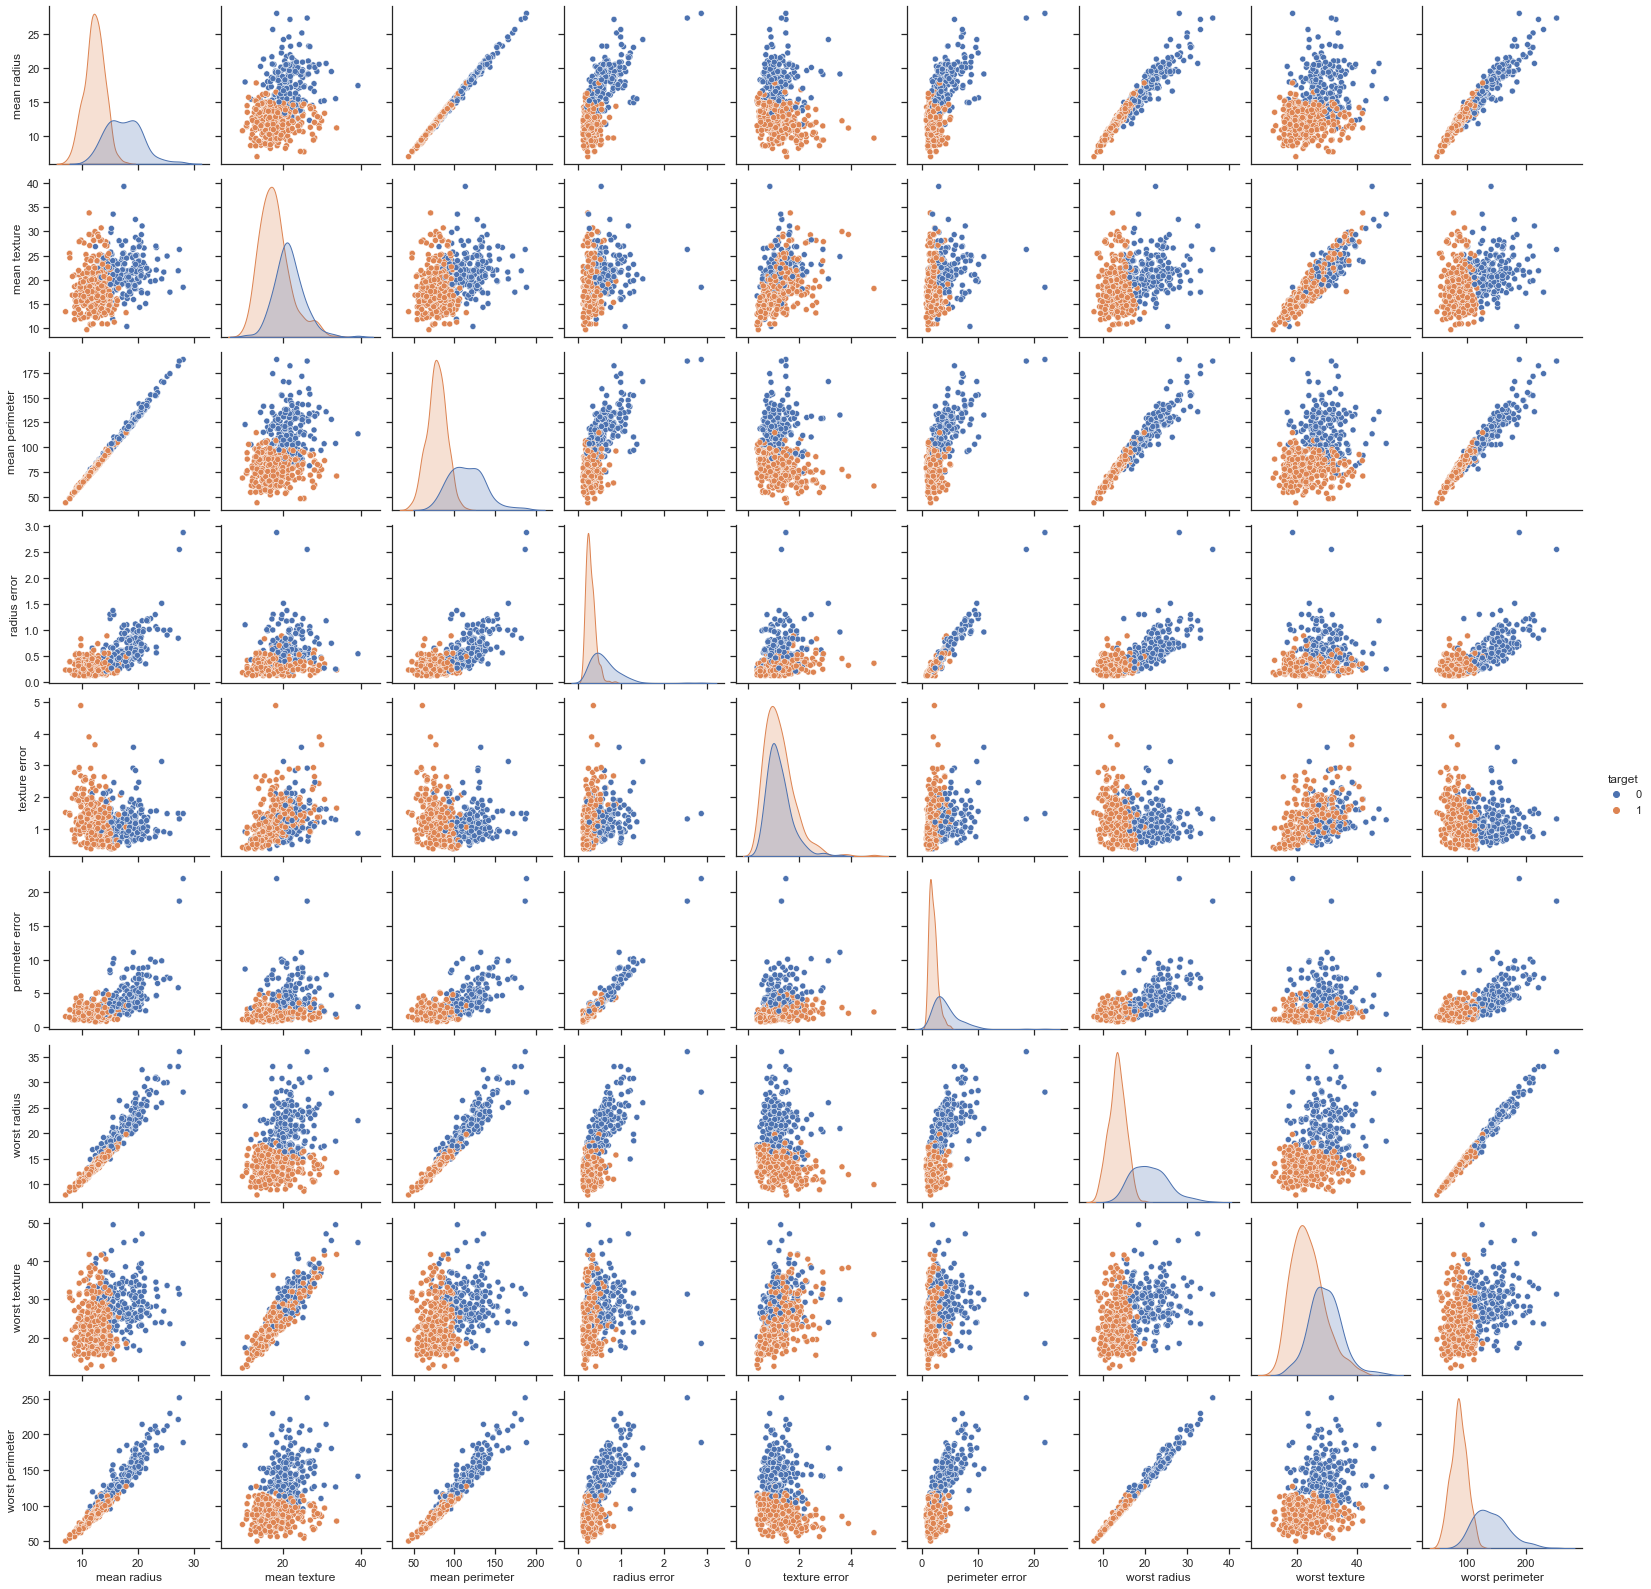

In [9]:
medias = np.append(X_names[:3], X_names[10:13]) # medias de los tres primeros atributos
varianzas = np.append(medias, X_names[20:23]) # varianzas de los tres primeros atributos
columnas = np.append(varianzas, ['target']) # peores de los tres primeros atributos
sns.pairplot(df[columnas], hue='target')

Seaborn es una librería de visualización de Python sobre _matplotlib_, es decir, estamos ante una libreria de alto nivel que nos facilita crear visualizaciones de forma más rápida, al mismo tiempo que más atractivas. Está perfectamente integrada con pandas, por lo que en pocas líneas podemos hacer representaciones como la anterior, pero si en su lugar trabajamos con _matplotlib_ y _numpy_ directamente, este proceso sería mas tedioso (creación de funciones, más líneas de código, etc.).

Respecto de los datos que hemos visualizado, vemos como en algunos ejemplos se pueden distinguir bien ambos conjuntos (malignos y benignos), como por ejemplo, si nos fijamos en la comparación entre la media del perimetro vs la peor textura. En un análisis estadistico de datos podríamos reducir los atributos (realizando más comprobaciones) que no nos ayuden a construir un buen modelo, lo que nos permite trabajar con menos atributos (más rendimiento, mejor generalización, etc.).

Ahora, vamos a definir una función (_buscaOutliers_) que nos permita obtener los ejemplos aislados. Como hemos comentado vamos a utilizar la clase `NearestNeighbors` de *Scikit-learn*, se trata de un modelo dentro de la familia de algorimos de vecinos cercanos, pero de los considerados "sin supervisión".

In [10]:
def buscaOutliers(k,r):
    resultado = []
    nn = NearestNeighbors(n_neighbors = k)
    nn.fit(X_data)
    _, indices = nn.kneighbors(X_data)
    for vecindario in indices: # Obtenemos el vecindario de cada instancia o ejemplo
        tipo_instancia = y_data[vecindario[0]]
        cercanos = vecindario[1:]
        tipos_cercanos = [y_data[vecino] for vecino in cercanos]
        # Si el numero de elementos distintos es mayor que el parametro r
        if (tipos_cercanos != tipo_instancia).sum() > r: 
            resultado.append(vecindario[0])
    return np.array(resultado)

Este modelo permite varios algoritmos de vecinos más próximos: `BallTree`, `KDTree` y fuerza bruta. Estos son la forma en la que el modelo "recuerda" los datos de entrenamiento. En nuestra implementación, no elegimos ningún algoritmo, por lo que va a intentar elegirlo automáticamente para obtener la mejor de todas en función de los datos de entrenamiento.

Respecto a la función _buscaOutliers_, el modelo `NearestNeighbors` nos va a devolver tanto los las distancias entre los vecinos, como cuales son los vecinos al llamar a `kneighbors`. A nosotros nos interesa lo segundo, ya que devuelve un array cuyo primer elemento es la instancia en cuestión y, el resto, son los indices de las instancias vecinas, siendo _k_ el tamaño del array.

Tras ello, vamos a utilizar la función anterior para obtener los ejemplos (5,3)-aislados y a construir un segundo conjunto de datos `Xo_data` sin esos ejemplos aislados.

In [11]:
indices_aislados = buscaOutliers(5,3)
Xo_data = np.delete(X_data, indices_aislados, axis=0)
yo_data = np.delete(y_data, indices_aislados, axis=0)
print("Instancias restantes: ", len(yo_data))

Instancias restantes:  555


Como vemos, hemos eliminado 14 ejemplos por estar considerados aislados.

### Modelos de decisión

Vamos a separar ambos conjuntos de datos (el original y el que ya no tiene ejemplos aislados) en sus respectivos conjuntos de entrenamiento (70% de las instancias) y de evaluación (30% de las instancias) para poder entrenar un modelo por cada uno de ellos y su posterior validación.

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = \
  train_test_split(X_data,y_data,test_size = 0.30,
                   random_state=4861,stratify=y_data)

In [14]:
Xo_train, Xo_test, yo_train, yo_test = \
  train_test_split(Xo_data,yo_data,test_size = 0.30,
                   random_state=4861,stratify=yo_data)

Una vez obtenidos todos los conjuntos, vamos a crear ambos modelos. En este caso, usamos `KNeughborsClassifier`, por lo que vamos a crear dos instancias del mismo modelo con los valores `k=5` (número de vecinos) y `p=1` (distancia Manhattan). En este caso, `k` respresenta el número de vecinos más cercanos a tener en cuenta para realizar una clasificación.

In [15]:
from sklearn.neighbors import KNeighborsClassifier

In [16]:
knn_X = KNeighborsClassifier(n_neighbors=5,p=1)

In [17]:
knn_Xo = KNeighborsClassifier(n_neighbors=5,p=1)

El número de vecinos se ha establecido en cinco debido a que para la eliminación de ejemplos aislados, hemos utilizado ese mismo valor. Es decir, tenemos un conjunto de datos en el que aquellos ejemplos donde los cinco vecinos adyacentes sean más de 3 de distinto tipo, sean eliminados. Por tanto, el segundo modelo debería puntuar mejor al no tener esos ejemplos aislados que pueden meter ruido (empeorar la evaluación).

El parámetro `p` se ha establecido en uno para utilizar la distancia Manhattan, ya que no vamos a medir propiedades similares. Como vimos, en el experimento con flores, todos los atributos eran similares ya que median longitudes en centímetros. Aquí, medimos cosas diferentes como distancias (radio), áreas (perimetro) o la escala de grises a partir de los píxeles de una imagen.

Ahora, vamos a entrenar ambos modelos.

In [18]:
knn_X.fit(X_train,y_train)
knn_X.predict(X_test)

array([1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1])

In [19]:
knn_Xo.fit(Xo_train,yo_train)
knn_Xo.predict(Xo_test)

array([1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

Al llamar al `predict` vemos la salida para cada conjunto de evaluación. Pero para sacar una medida de rendimiento (% de acierto) podemos usar `score`.

In [20]:
knn_X.score(X_test,y_test)

0.9473684210526315

In [21]:
knn_Xo.score(Xo_test,yo_test)

0.9520958083832335

### Conlusiones

El primer modelo, en el que entrenamos a partir del conjunto original o `X_data`, obtenemos una puntuación de 0.947 o un acierto del 94.7% de los casos. En el segundo modelo, en el que entrenamos a partir del conjunto en el que hemos eliminados aquellas instancias aisladas, obtenemos una leve mejora, siendo la puntuación de 0.952 o un acierto del 95.2%.

La diferencia es mínima, pero se puede explicar a partir que partimos de un conjunto con menos "ruido", lo que va a permitir eliminar instancias que dificultan trazar, digamos, "una línea" entre las dos clasificaciones.

No obstante, en modelos de aprendizaje automático, puede no interesar un porcentaje tan cercano al 100%, ya que podemos caer en el _sobreajuste_, aunque aquí estamos trabajando con modelos que "recuerdan" el conjunto de entrenamiento y, por tanto, que no generalizan.